In [1]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline


In [2]:
mylearnrate = 1e-3
batchsize = 32
mymomentum = 0.9
epochs = 500
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
dropout = 0.2
inputdata = 'resized224_augm' # choose cropped, resized128, resized224
test_batchsize = 32 #total pictures in test
limit = 0.01    



In [3]:
if inputdata == 'cropped':
    dataset_path = "./apple_cropped"
elif inputdata == 'resized128':
    dataset_path = "./apple_resized_128/Train"
elif inputdata == 'resized224':
    dataset_path = './apple_resized_224/Train'
elif inputdata == 'resized224_augm':
    dataset_path = './apple_resized_224_augm/Train'
print(dataset_path)

./apple_resized_224_augm/Train


In [4]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 115
Normal_Apple 87
Rot_Apple 114
Scab_Apple 85


In [5]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e


transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
])
dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [6]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [7]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [8]:
print(train_dataset[1][0][:, 112:116, 112:116])

tensor([[[0.2588, 0.3137, 0.3882, 0.4157],
         [0.3020, 0.3333, 0.3843, 0.4078],
         [0.3569, 0.3647, 0.3882, 0.4039],
         [0.3843, 0.3725, 0.3843, 0.4078]],

        [[0.2627, 0.3176, 0.3961, 0.4275],
         [0.3059, 0.3373, 0.3922, 0.4196],
         [0.3608, 0.3725, 0.3961, 0.4157],
         [0.3922, 0.3804, 0.3961, 0.4196]],

        [[0.0980, 0.1451, 0.2039, 0.2196],
         [0.1412, 0.1647, 0.2078, 0.2118],
         [0.1882, 0.1882, 0.2039, 0.2000],
         [0.2000, 0.1882, 0.1882, 0.1961]]])


In [9]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=0)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [10]:
import torch.nn.functional as F
import random

class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 4)
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor from 3 channel RGB 
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = F.relu(self.fc3(x))
        x = self.drop1(x)

        return self.fc4(x)

In [11]:

myMLP = MLP()
myMLP.to(device)

import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()

if optchoice == 'adam':
    optimizer = optim.Adam(myMLP.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(myMLP.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = sgd')


optimizer = sgd


<Figure size 640x480 with 0 Axes>

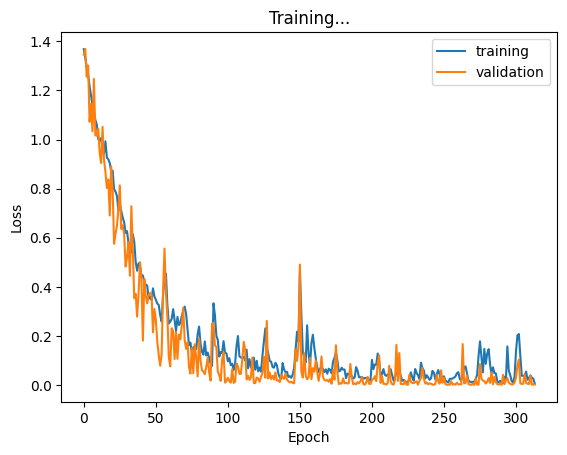

Early stopping


In [12]:
# Train function

import realtime_graph as graph

epochresults = []
epoch_valloss = 0 
graph.startplot()


for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    myMLP.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myMLP.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myMLP.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = myMLP.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()
        

    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

        
    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_loss<0.01:
        print("Early stopping")
        break

In [13]:
dataset_path_test = "./apple_resized_224/Test"

transform_img_grayscale = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Grayscale(1) 
])

dataset_test = ImageFolder(dataset_path_test, transform=transform_img_grayscale)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=False)

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myMLP.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

            
        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[predicted[i]][labels[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)
print(total)

Accuracy of the network on the test images: 54 %
Confusion Matrix:
[[17.  9.  0.  9.]
 [ 2.  4.  0.  3.]
 [ 2.  2. 35.  7.]
 [ 9.  9.  3.  9.]]
120


In [15]:
width, height = confusion_matrix.shape
normtotal = 0
normcorrect = confusion_matrix[1][1]
for i in range(height):
    normtotal += confusion_matrix[i][1]

accuracy_normal_apple = round((normcorrect/normtotal)*100, 1)

print('Accuracy on Normal Apples:'+str(accuracy_normal_apple)+'%')

Accuracy on Normal Apples:16.7%


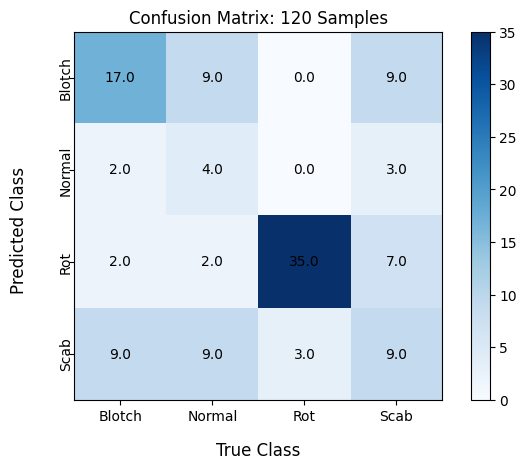

In [16]:
# Define class labels
class_labels = ['Blotch', 'Normal', 'Rot', 'Scab']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(confusion_matrix, cmap='Blues')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis ticks and labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Set the title
ax.set_title("Confusion Matrix: 120 Samples")

# Display axis meaning
ax.text(0.5, -0.15, f"True Class", transform=ax.transAxes,
        fontsize=12, ha='center')
ax.text(-0.15, 0.3, f"Predicted Class", rotation=90, transform=ax.transAxes,
        fontsize=12, ha='center')


# Show the figure
plt.tight_layout()
plt.show()


In [17]:
# >>> from torchmetrics.classification import MulticlassConfusionMatrix
# >>> target = torch.tensor([2, 1, 0, 0])
# >>> preds = torch.tensor([
# ...   [0.16, 0.26, 0.58],
# ...   [0.22, 0.61, 0.17],
# ...   [0.71, 0.09, 0.20],
# ...   [0.05, 0.82, 0.13],
# ... ])
# >>> metric = MulticlassConfusionMatrix(num_classes=3)
# >>> metric(preds, target)
# tensor([[1, 1, 0],
#         [0, 1, 0],
#         [0, 0, 1]])

In [ ]:

torch.save(myMLP, 'apple_mlp_classifier.pt')